## **DCGANs**

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.datasets as dataset
from torchvision.utils import make_grid
from tqdm.auto import tqdm

import numpy as np
import matplotlib.pyplot as plt

### A look at Transposed Convolution before moving on to DCGANs

torch.Size([1, 1, 3, 3])


[]

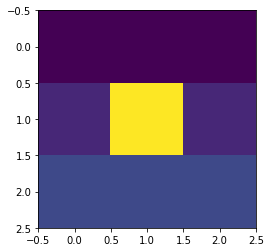

In [ ]:
x = torch.Tensor([[[[1,1,1], [2,10,2], [3,3,3]]]])
print(x.shape)
plt.imshow(x[0, 0, ...])
plt.plot()

In [ ]:
y = nn.ConvTranspose2d(in_channels=1, out_channels=3, kernel_size=3, stride=1)
b = y(x)
print(b.shape)

torch.Size([1, 3, 5, 5])


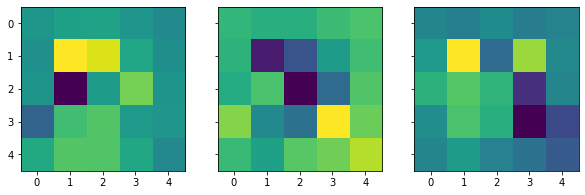

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=b.shape[1], sharex=True, sharey=True, figsize=(10, 8))
for i in range(b.shape[1]):
  ax[i].imshow(b[0,i,...].detach().numpy())

## **Getting Started**

### Loading MNIST Dataset and Visualization

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    transforms.Normalize((0.5,), (0.5,)),
])

trainset = dataset.MNIST('MNIST', train=True,
                           transform=transform, download=True)
train_loader = DataLoader(trainset, batch_size = 128,
                          shuffle=True)

In [ ]:
def show(images, num_images, size, nrows):
  images = (images + 1) / 2
  grid = make_grid(images.detach().cpu()[:num_images], nrow=nrows).permute(1,2,0).squeeze()
  plt.imshow(grid)
  plt.show()

In [ ]:
for i, image in enumerate(train_loader):
  img = image[0]

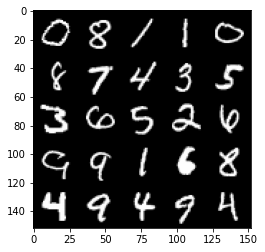

In [ ]:
show(img, 25, (1, 28, 28), 5)

## **Generator**

In [ ]:
def generator_block(input, output, kernel_size=3, stride=2, last_layer=False):
  if not last_layer:
    x = nn.Sequential(
        nn.ConvTranspose2d(in_channels=input, out_channels=output,
                          kernel_size=kernel_size, stride=stride),
        nn.BatchNorm2d(output),
        nn.ReLU(inplace=True)
    )
  else:
    x = nn.Sequential(
        nn.ConvTranspose2d(in_channels=input, out_channels=output,
                           kernel_size=kernel_size, stride=stride),
        nn.Tanh()
    )
  return x

In [ ]:
class Generator(nn.Module):
  def __init__(self, noise_dim, image_dim, hidden_dim):
    super(Generator, self).__init__()
    self.noise_dim = noise_dim
    self.generator = nn.Sequential(
        generator_block(noise_dim, hidden_dim * 4),
        generator_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
        generator_block(hidden_dim * 2, hidden_dim),
        generator_block(hidden_dim, image_dim, kernel_size=4, last_layer=True)
    )

  def forward(self, noise):
    noise = noise.view(len(noise), self.noise_dim, 1, 1) # [128, 64, 1, 1]
    x = self.generator(noise)
    return x

In [ ]:
def get_noise_vectors(n_samples, noise_dim, device='cpu'):
  return torch.randn(n_samples, noise_dim, device=device)

## **Discriminator**

In [ ]:
def discriminator_block(input, output, kernel_size=4, stride=2, last_layer=False):
  if not last_layer:
    x = nn.Sequential(
        nn.Conv2d(in_channels=input, out_channels=output,
                  kernel_size=kernel_size, stride=stride),
        nn.BatchNorm2d(output),
        nn.LeakyReLU(0.2, inplace=True)
    )
  else:
    x = nn.Sequential(
        nn.Conv2d(in_channels=input, out_channels=output,
                  kernel_size=kernel_size, stride=stride)
    )
  return x

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, image_dim, hidden_dim):
    super(Discriminator, self).__init__()
    self.discr = nn.Sequential(
        discriminator_block(image_dim, hidden_dim),
        discriminator_block(hidden_dim, hidden_dim * 2),
        discriminator_block(hidden_dim * 2, 1, last_layer=True)
    )

  def forward(self, image):
    x = self.discr(image)
    return x.view(len(x), -1)

## **Initializing Generator and Discriminator**

In [ ]:
criterion = nn.BCEWithLogitsLoss()
noise_dim = 64
lr = 0.0002
batch_size = 128
step = 500

image_channels = 1
hidden_dim_gen = 64
hidden_dim_discr = 16

# Parameters for controlling optimizer's momentum
beta_1 = 0.5
beta_2 = 0.999

device = 'cuda'

In [ ]:
gen = Generator(noise_dim, image_channels, hidden_dim_gen).to(device)
gen_optimizer = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
discr = Discriminator(image_channels, hidden_dim_discr).to(device)
discr_optimizer = torch.optim.Adam(discr.parameters(), lr=lr, betas=(beta_1, beta_2))

def init_weights(layer):
  if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.ConvTranspose2d):
    torch.nn.init.normal_(layer.weight, 0.0, 0.02)
  if isinstance(layer, nn.BatchNorm2d):
      torch.nn.init.normal_(layer.weight, 0.0, 0.02)
      torch.nn.init.constant_(layer.bias, 0)

gen = gen.apply(init_weights)
discr = discr.apply(init_weights)

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 500: Generator Loss: 0.909124017357826, Discr Loss: 0.5298313971161841


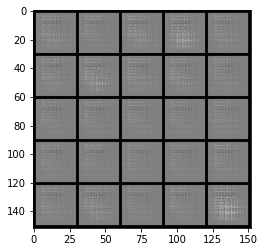

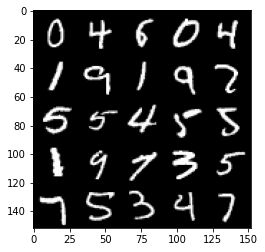

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1000: Generator Loss: 2.4210598287582403, Discr Loss: 0.1273056519925594


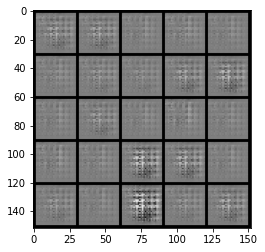

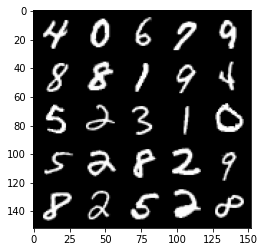

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1500: Generator Loss: 3.5943633472323424, Discr Loss: 0.06841195754334327


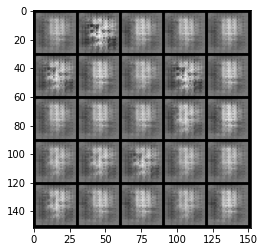

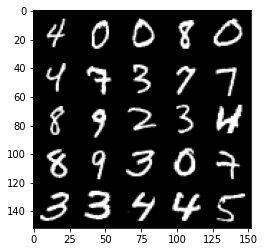

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2000: Generator Loss: 1.5709181941747665, Discr Loss: 0.42294198653101933


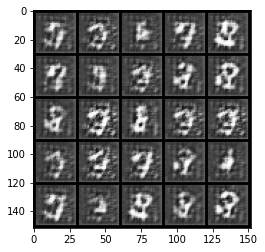

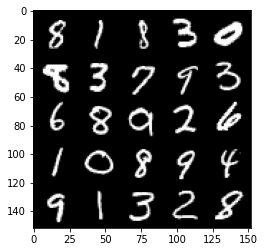

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2500: Generator Loss: 1.2493978587090975, Discr Loss: 0.48389151257276564


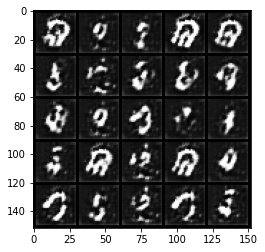

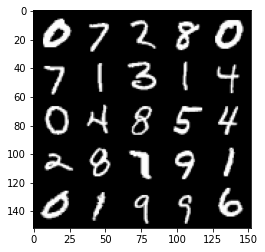

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3000: Generator Loss: 1.0978754416108136, Discr Loss: 0.5148174804449079


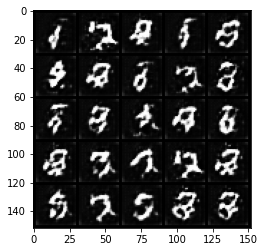

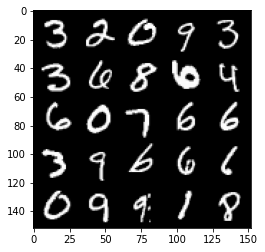

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3500: Generator Loss: 0.9990570811033243, Discr Loss: 0.5493233229517935


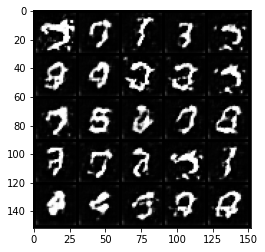

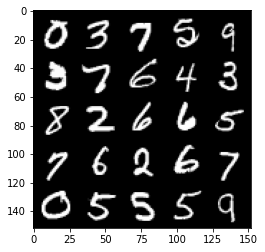

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4000: Generator Loss: 0.8980342134237289, Discr Loss: 0.5881074331998826


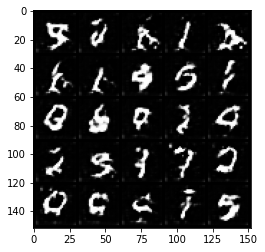

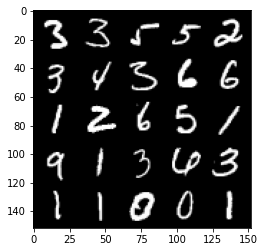

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4500: Generator Loss: 0.8798669929504399, Discr Loss: 0.6152803267240521


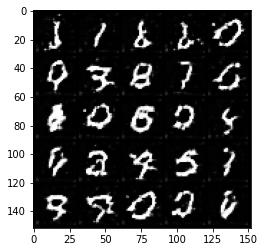

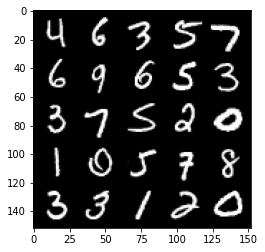

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5000: Generator Loss: 0.8639409453868863, Discr Loss: 0.6205354211330408


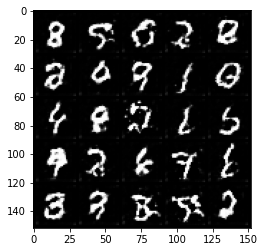

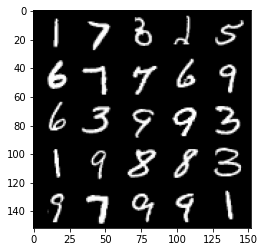

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5500: Generator Loss: 0.8547971721291536, Discr Loss: 0.6263096603155132


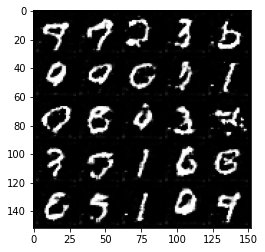

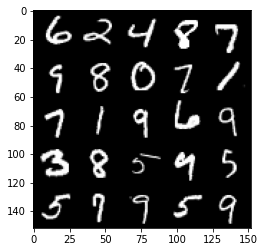

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6000: Generator Loss: 0.8350044907927507, Discr Loss: 0.6387851638793943


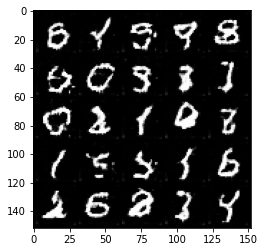

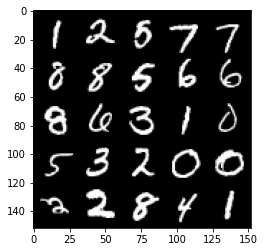

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6500: Generator Loss: 0.8209602528810509, Discr Loss: 0.6462383399009709


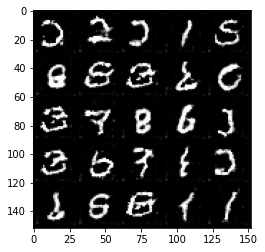

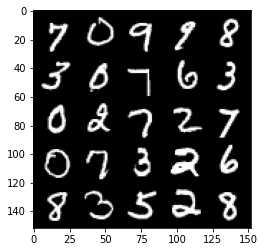

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7000: Generator Loss: 0.8108613358736037, Discr Loss: 0.6493250542879105


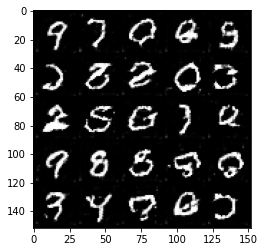

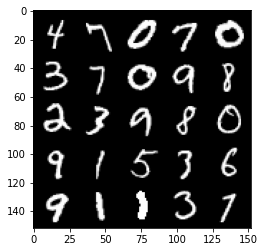

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7500: Generator Loss: 0.7953492730259893, Discr Loss: 0.6588295464515687


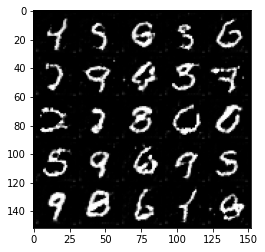

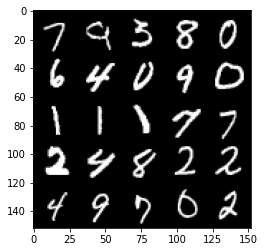

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8000: Generator Loss: 0.7837537767887113, Discr Loss: 0.6668796443939199


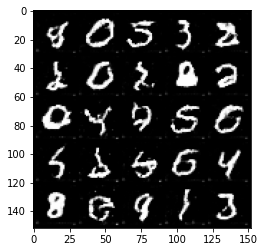

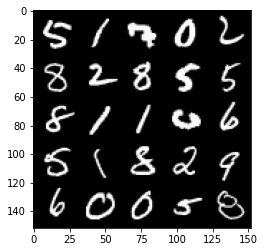

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8500: Generator Loss: 0.7813893443346028, Discr Loss: 0.6722966964244843


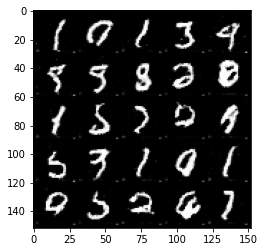

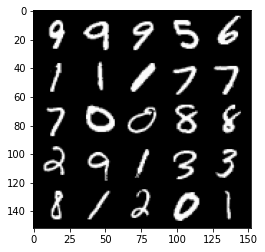

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9000: Generator Loss: 0.7657114435434349, Discr Loss: 0.676543487668038


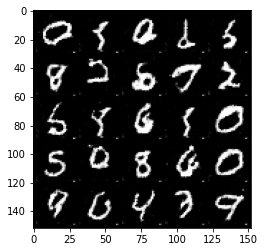

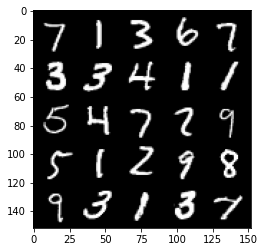

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9500: Generator Loss: 0.7582691013216974, Discr Loss: 0.6818190175294877


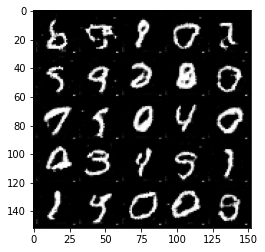

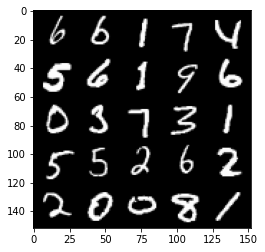

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10000: Generator Loss: 0.7538042627573016, Discr Loss: 0.6853271167278285


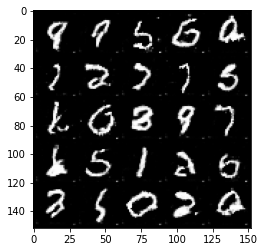

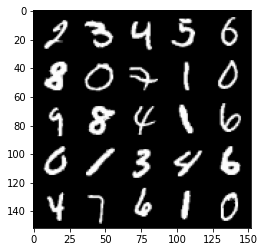

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10500: Generator Loss: 0.74882766932249, Discr Loss: 0.6889133424758908


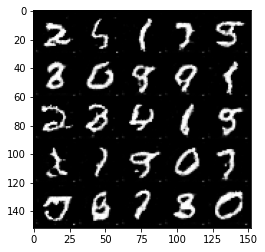

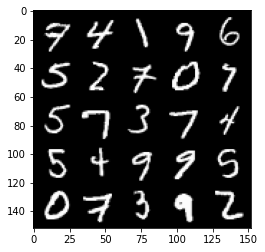

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11000: Generator Loss: 0.7387030835151667, Discr Loss: 0.6915255799293515


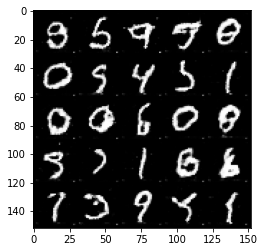

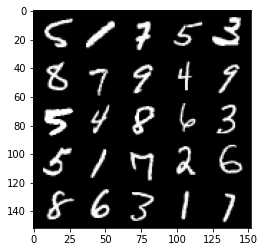

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11500: Generator Loss: 0.7309361435174943, Discr Loss: 0.6920832394361492


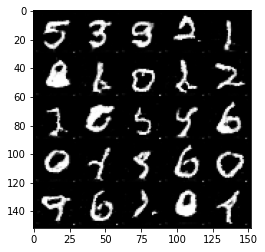

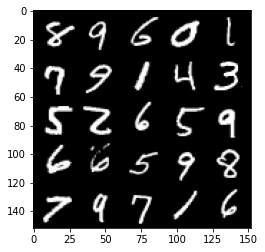

  0%|          | 0/469 [00:00<?, ?it/s]

Step 12000: Generator Loss: 0.7289158018231389, Discr Loss: 0.6933179450035093


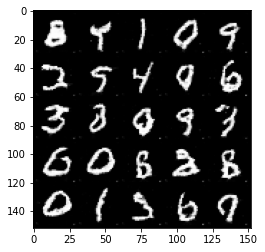

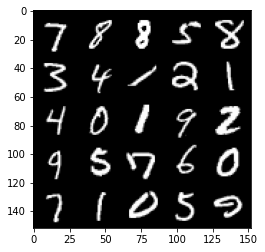

  0%|          | 0/469 [00:00<?, ?it/s]

In [ ]:
epochs = 50
cur_step = 0
mean_gen_loss = 0
mean_disc_loss = 0

for epoch in range(epochs):
  for image, _ in tqdm(train_loader):
    curr_batch_size = len(image)
    image = image.to(device)

    # Update Discriminator
    discr_optimizer.zero_grad()
    fake_noise = get_noise_vectors(curr_batch_size, noise_dim, device)
    fake = gen(fake_noise)
    fake_pred = discr(fake.detach())
    discr_loss_fake = criterion(fake_pred, torch.zeros_like(fake_pred))
    real_pred = discr(image)
    discr_loss_real = criterion(real_pred, torch.ones_like(real_pred))
    disc_loss = (discr_loss_fake + discr_loss_real) / 2

    # Average Discriminator Loss
    mean_disc_loss += disc_loss.item() / step
    disc_loss.backward(retain_graph=True)
    discr_optimizer.step()

    # Update Generator
    gen_optimizer.zero_grad()
    fake_noise_g = get_noise_vectors(curr_batch_size, noise_dim, device)
    fake_g = gen(fake_noise_g)
    fake_pred = discr(fake_g)
    gen_loss = criterion(fake_pred, torch.ones_like(fake_pred))
    gen_loss.backward()
    gen_optimizer.step()

    # Average Generator Loss
    mean_gen_loss += gen_loss.item() / step

    # Progress and Visualization
    if cur_step % step == 0 and cur_step > 0:
      print("Step {}: Generator Loss: {}, Discr Loss: {}".format(cur_step, mean_gen_loss, mean_disc_loss))
      show(fake, 25, (1,28,28), 5)
      show(image, 25, (1,28,28), 5)
      mean_gen_loss = 0
      mean_disc_loss = 0
    cur_step += 1